<h1> Data Science Challenge - Cayena </h1>
Author: Matheus Ferreira Nunes



<h4> This work refers to the Data Science Challenge by Cayena, as a requisite for the Senior Data Scientist application.

# Data ingestion

In [ ]:
%pip install -r notebook_requirements.txt

In [1]:
import time
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv as catboost_cv
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# creating a pandas dataframe to hold the dataset, one which will be immutable, and another that can be edited

data = pd.read_csv("dataset_ds_case.csv")
df = deepcopy(data)

# Data exploration

<h4> In this step, the objective is to understand and explore patterns, anomalies, key variables, and relationships. </h4>

In [3]:
df.tail(5)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,total_quantity,augmented_quantity,FU,City,CEP,date_time_login,date_time_confirm,TARGET
10298,-403.693167,-742.755107,1397.307672,-160.880009,-632.798625,-1176.385310,408.378859,-70.682440,116,384,SP,São Paulo,8253410,2022-06-08 07:40:12,2022-06-08 07:40:23,0
10299,-868.672887,-1222.476834,876.849958,1437.451975,453.010381,-154.234538,721.344563,894.131014,133,854,RJ,Duque de Caxias,25215200,2022-03-04 21:43:30,2022-03-04 21:43:46,0
10300,-847.146017,5.850120,1864.705697,790.580267,-1520.431131,-673.618866,-153.226434,57.148326,137,974,SP,São Paulo,8040220,2022-03-04 05:00:52,2022-03-04 05:01:01,0
10301,1821.115429,755.000237,-680.631451,873.842151,958.582568,836.762092,293.497906,-1289.087525,119,462,MG,Belo Horizonte,31510010,2022-03-29 22:07:55,2022-03-29 22:08:15,0
10302,301.948810,-1188.162175,626.798696,-32.753325,-567.381493,-647.681605,397.323511,-537.857374,128,709,SP,São Paulo,8420400,2022-05-18 15:08:00,2022-05-18 15:08:12,1


In [4]:
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,total_quantity,augmented_quantity,CEP,TARGET
count,10303.000000,10303.000000,10303.000000,10303.000000,10303.000000,10303.000000,10303.000000,10303.000000,10303.000000,10303.000000,1.030300e+04,10303.000000
mean,3.685448,-3.049959,-12.589034,3.707894,-426.616870,-31.516981,-9.163972,393.507106,120.244298,506.697467,2.005743e+07,0.125012
std,960.241305,800.229513,793.214795,803.752045,1075.209503,958.674680,804.078080,718.471694,10.903613,265.390015,1.019713e+07,0.330749
min,-3714.334290,-2776.208646,-2716.109790,-3412.489635,-5227.444477,-4007.051453,-3026.439775,-2671.565898,79.000000,0.000000,7.050301e+06,0.000000
25%,-621.303182,-546.050747,-546.320628,-543.081755,-1098.625890,-673.466568,-547.636981,-82.294473,113.000000,307.000000,8.412006e+06,0.000000
50%,-249.841042,-2.380534,-6.723935,-9.701843,-406.463868,22.724719,-1.255940,404.554328,120.000000,488.000000,2.132109e+07,0.000000
75%,524.483447,536.684808,527.594590,533.939334,273.950480,647.115924,535.713950,891.327239,128.000000,709.000000,2.918217e+07,0.000000
max,4906.998727,2824.625851,3075.793998,3003.247029,4498.520584,3553.810815,3758.620770,3197.288304,166.000000,1097.000000,3.808006e+07,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10303 entries, 0 to 10302
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   col_0               10303 non-null  float64
 1   col_1               10303 non-null  float64
 2   col_2               10303 non-null  float64
 3   col_3               10303 non-null  float64
 4   col_4               10303 non-null  float64
 5   col_5               10303 non-null  float64
 6   col_6               10303 non-null  float64
 7   col_7               10303 non-null  float64
 8   total_quantity      10303 non-null  int64  
 9   augmented_quantity  10303 non-null  int64  
 10  FU                  10303 non-null  object 
 11  City                10303 non-null  object 
 12  CEP                 10303 non-null  int64  
 13  date_time_login     10303 non-null  object 
 14  date_time_confirm   10303 non-null  object 
 15  TARGET              10303 non-null  int64  
dtypes: f

In [6]:
df["TARGET"].value_counts()

0    9015
1    1288
Name: TARGET, dtype: int64

In [7]:
df["TARGET"].value_counts(normalize=True)

0    0.874988
1    0.125012
Name: TARGET, dtype: float64

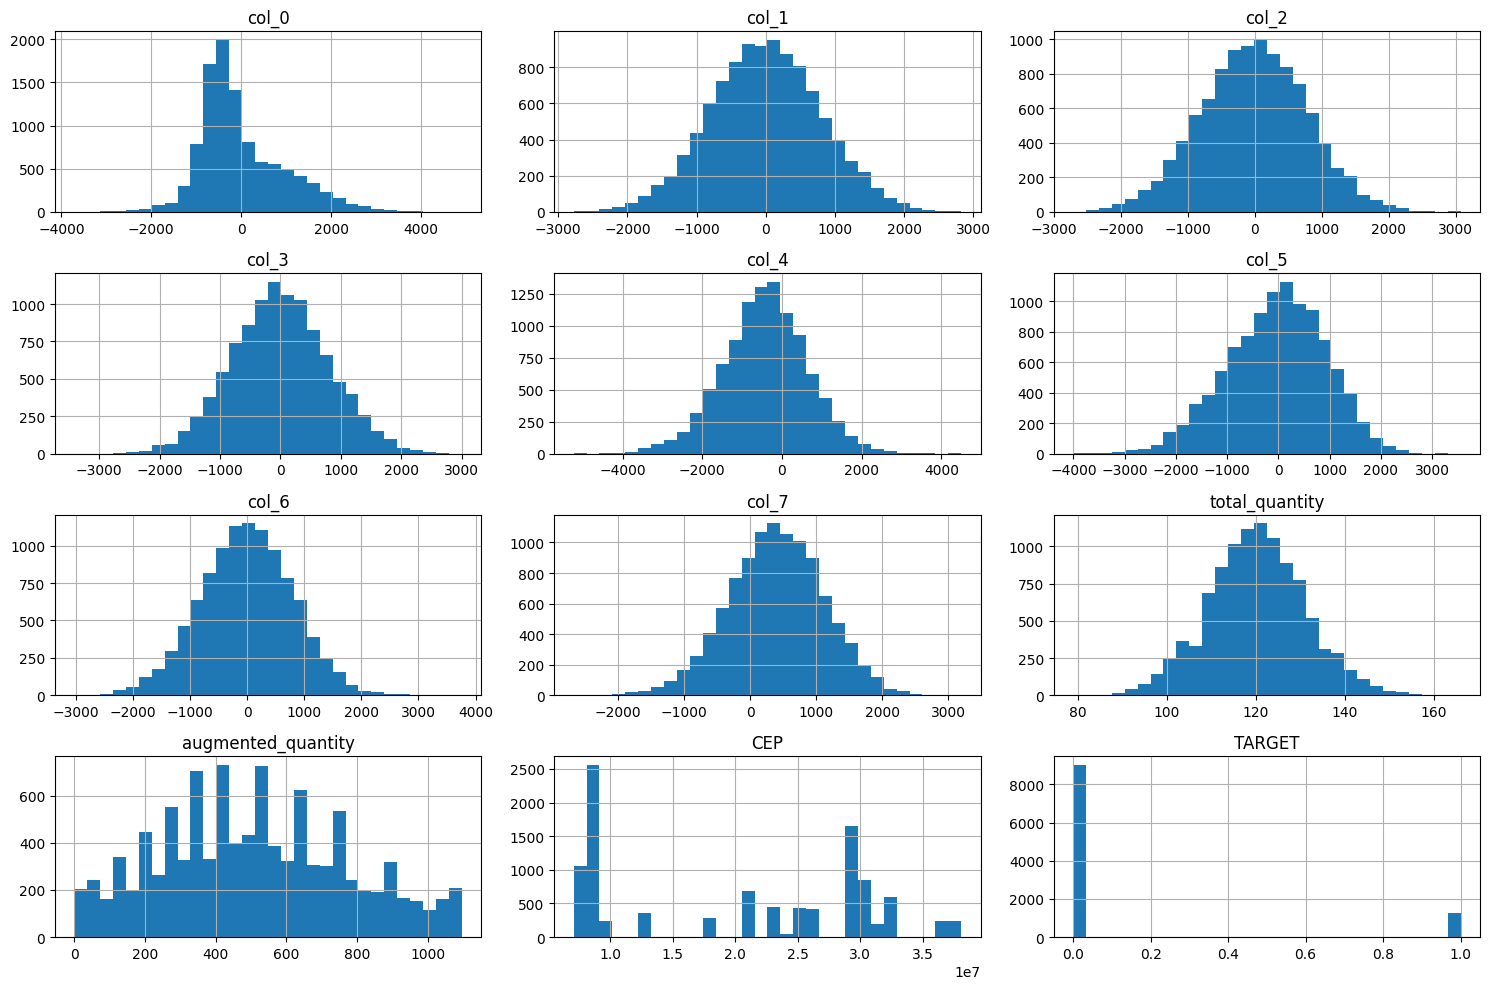

In [8]:
# Distribution of numerical features
data.select_dtypes(include=[float, int]).hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

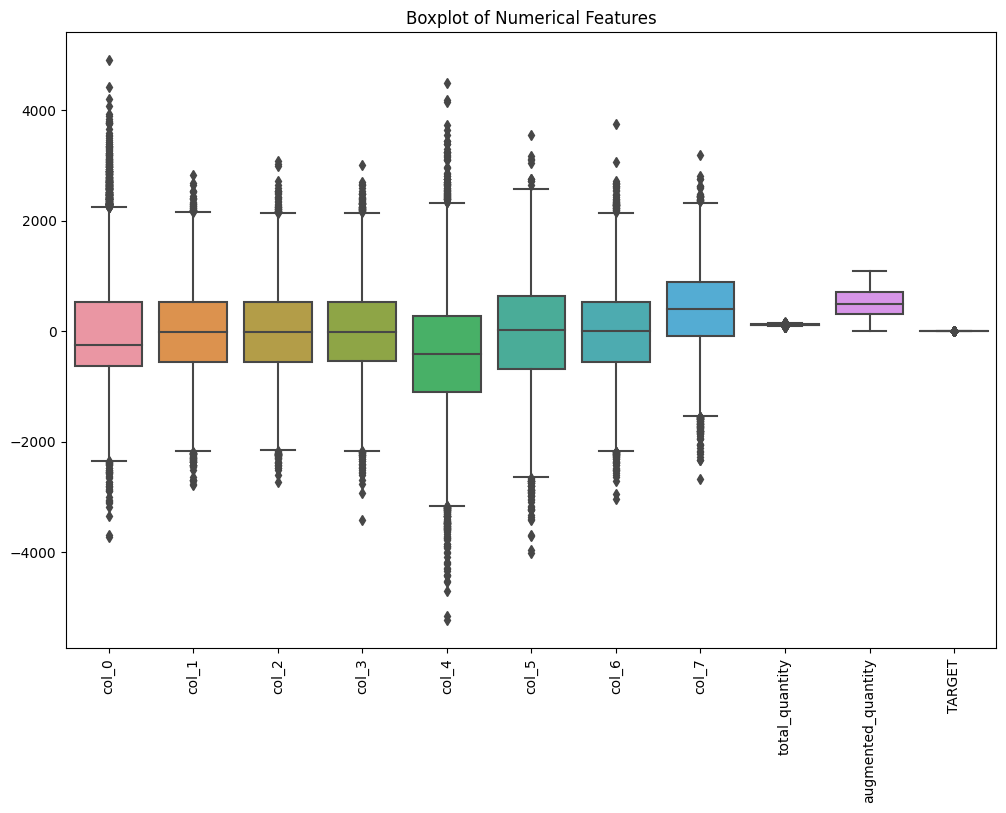

In [9]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop("CEP", axis=1).select_dtypes(include=[float, int]))
plt.xticks(rotation=90)
plt.title('Boxplot of Numerical Features')
plt.show()

/tmp/ipykernel_103799/2328133870.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


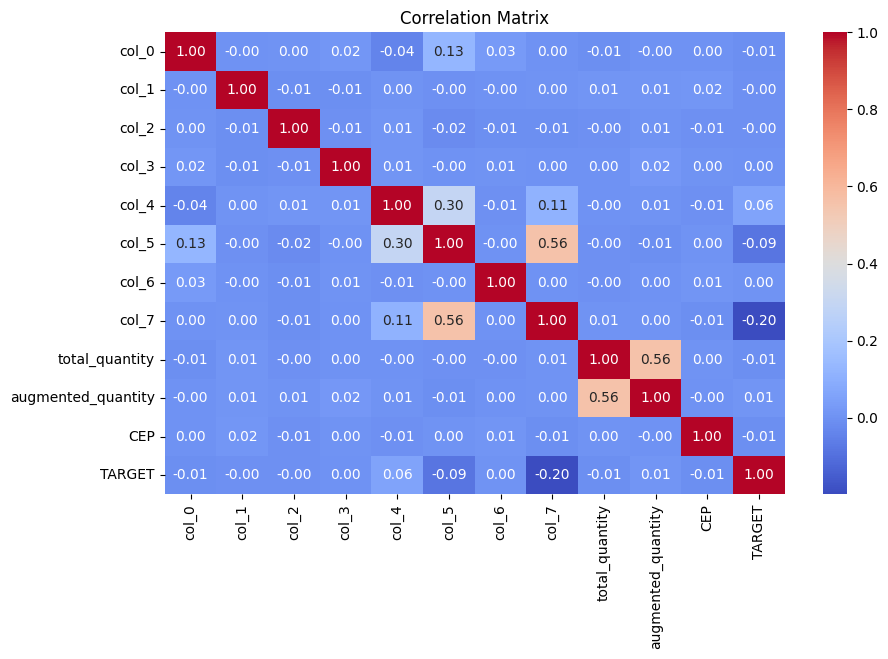

In [10]:
# Correlation matrix and heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

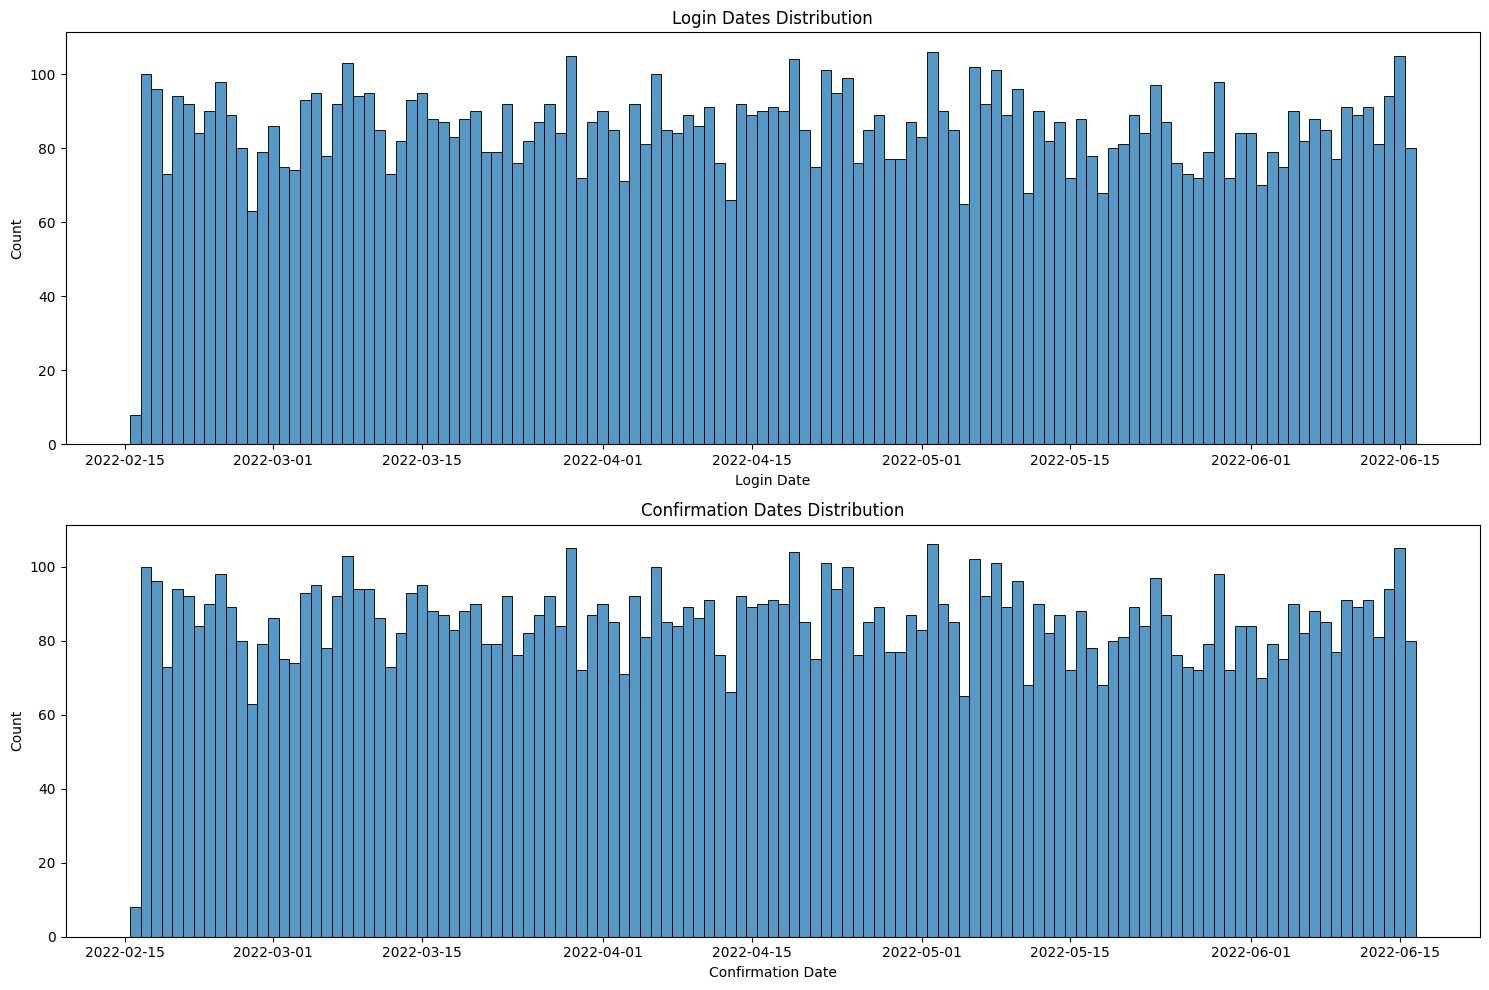

In [11]:
# Convert date_time columns to datetime format
df['date_time_login'] = pd.to_datetime(df['date_time_login'])
df['date_time_confirm'] = pd.to_datetime(df['date_time_confirm'])

# Extract date and time components for analysis
df['login_date'] = df['date_time_login'].dt.date
df['login_time'] = df['date_time_login'].dt.time
df['confirm_date'] = df['date_time_confirm'].dt.date
df['confirm_time'] = df['date_time_confirm'].dt.time

# Plot the count of logins and confirmations over time
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.histplot(df['login_date'], bins=30, kde=False, ax=axes[0])
axes[0].set_title('Login Dates Distribution')
axes[0].set_xlabel('Login Date')
axes[0].set_ylabel('Count')

sns.histplot(df['confirm_date'], bins=30, kde=False, ax=axes[1])
axes[1].set_title('Confirmation Dates Distribution')
axes[1].set_xlabel('Confirmation Date')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

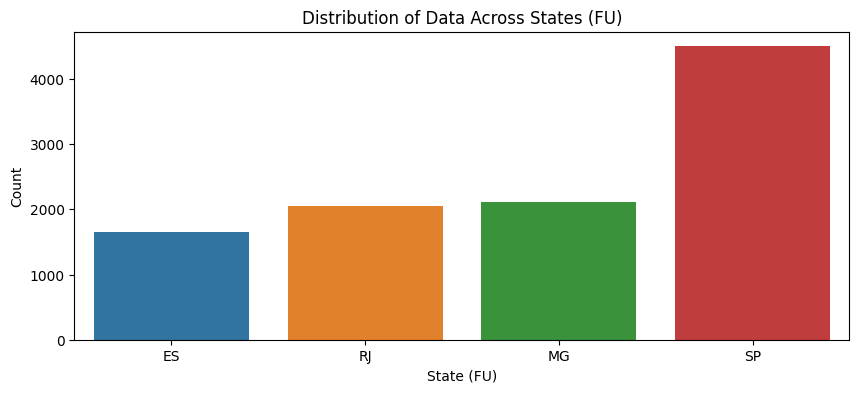

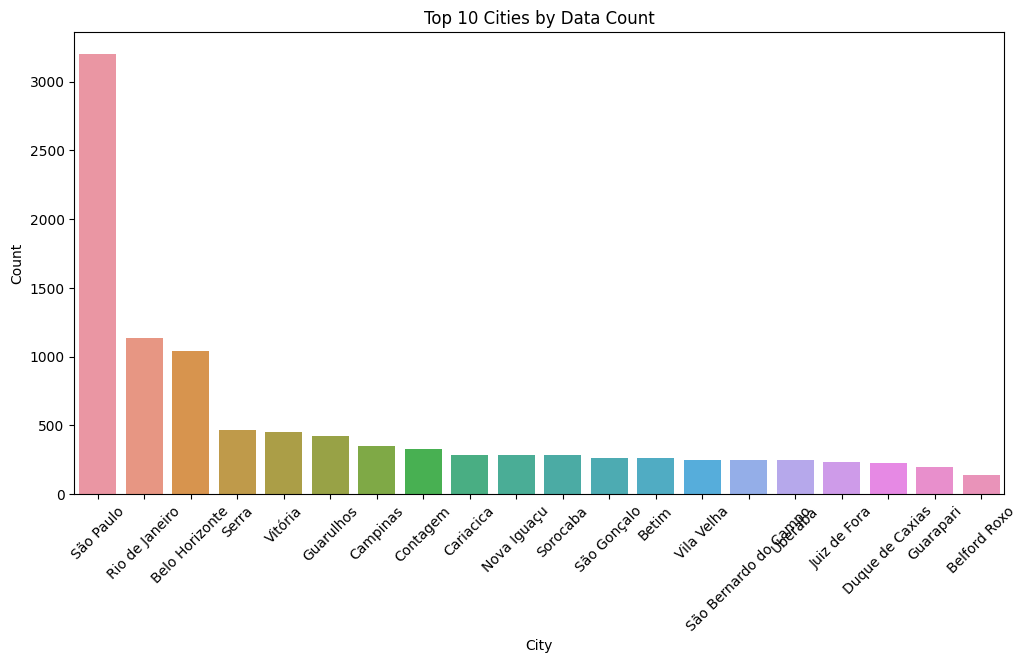

In [12]:
# Plot the distribution of data across different states (FU)
plt.figure(figsize=(10, 4))
sns.countplot(x='FU', data=data)
plt.title('Distribution of Data Across States (FU)')
plt.xlabel('State (FU)')
plt.ylabel('Count')
plt.show()

# Plot the top 10 cities by data count
top_cities = data['City'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title('Top 10 Cities by Data Count')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

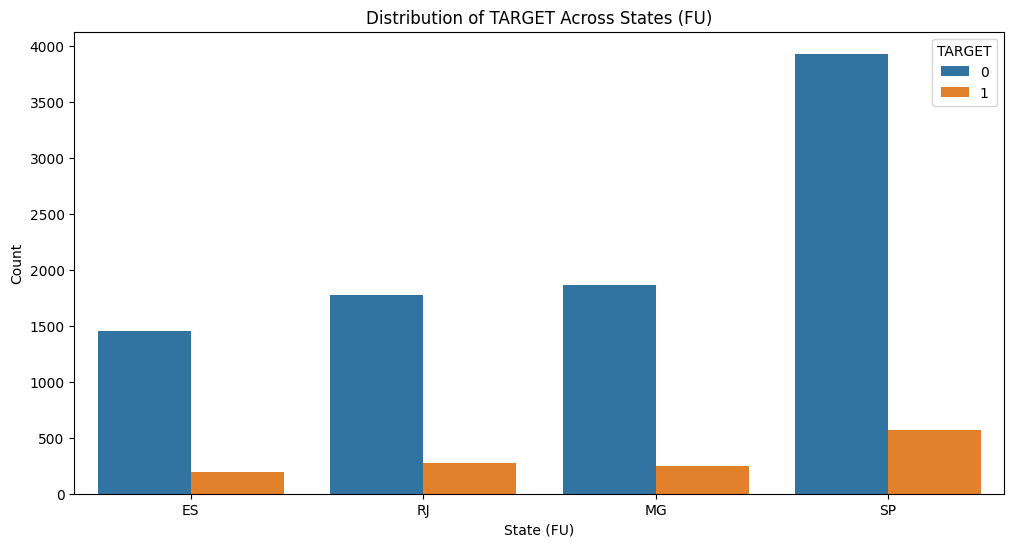

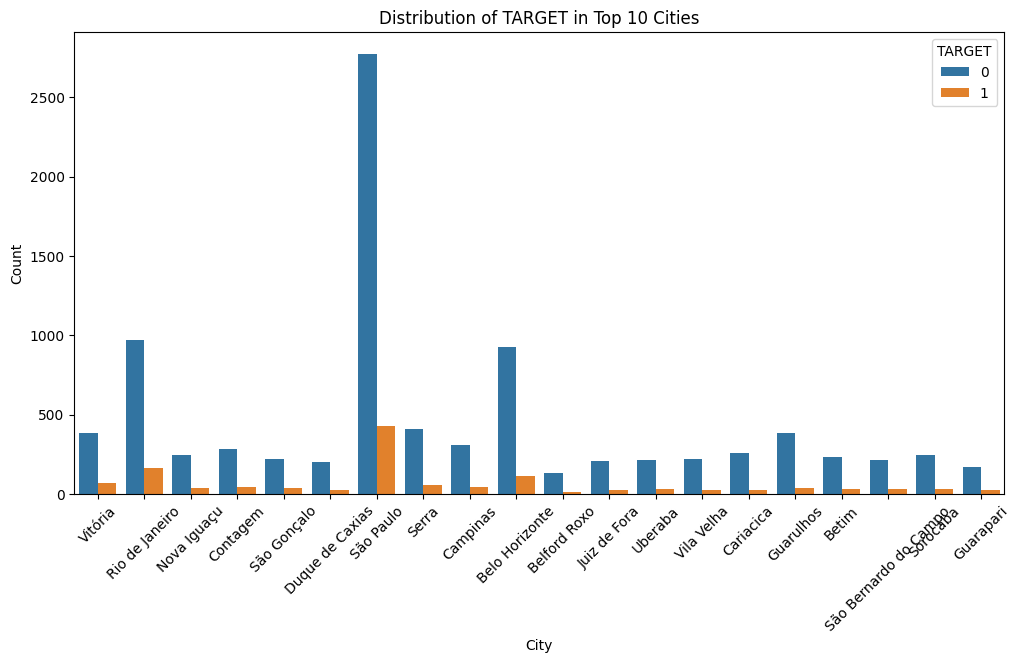

In [13]:
# Plot the distribution of TARGET across different states (FU)
plt.figure(figsize=(12, 6))
sns.countplot(x='FU', hue='TARGET', data=data)
plt.title('Distribution of TARGET Across States (FU)')
plt.xlabel('State (FU)')
plt.ylabel('Count')
plt.legend(title='TARGET')
plt.show()

# Plot the distribution of TARGET for the top 10 cities
top_cities_target = data[data['City'].isin(top_cities.index)]
plt.figure(figsize=(12, 6))
sns.countplot(x='City', hue='TARGET', data=top_cities_target)
plt.title('Distribution of TARGET in Top 10 Cities')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='TARGET')
plt.show()


In [14]:
# Calculate the proportion of TARGET=1 to TARGET=0 for each state
city_target_proportion = data.groupby('FU')['TARGET'].value_counts(normalize=True).unstack().fillna(0)
city_target_proportion['Proportion_Target_1_to_0'] = city_target_proportion[1] / city_target_proportion[0]

city_target_proportion

TARGET,0,1,Proportion_Target_1_to_0
FU,,,
ES,0.880996,0.119004,0.135079
MG,0.881685,0.118315,0.134192
RJ,0.866928,0.133072,0.153499
SP,0.873305,0.126695,0.145075


In [15]:
# Calculate the proportion of TARGET=1 to TARGET=0 for each city
city_target_proportion = data.groupby('City')['TARGET'].value_counts(normalize=True).unstack().fillna(0)
city_target_proportion['Proportion_Target_1_to_0'] = city_target_proportion[1] / city_target_proportion[0]

city_target_proportion

TARGET,0,1,Proportion_Target_1_to_0
City,,,
Belford Roxo,0.928571,0.071429,0.076923
Belo Horizonte,0.892411,0.107589,0.120560
Betim,0.877863,0.122137,0.139130
Campinas,0.880682,0.119318,0.135484
Cariacica,0.909091,0.090909,0.100000
Contagem,0.857576,0.142424,0.166078
Duque de Caxias,0.901786,0.098214,0.108911
Guarapari,0.876289,0.123711,0.141176
Guarulhos,0.909524,0.090476,0.099476


<Figure size 1500x700 with 0 Axes>

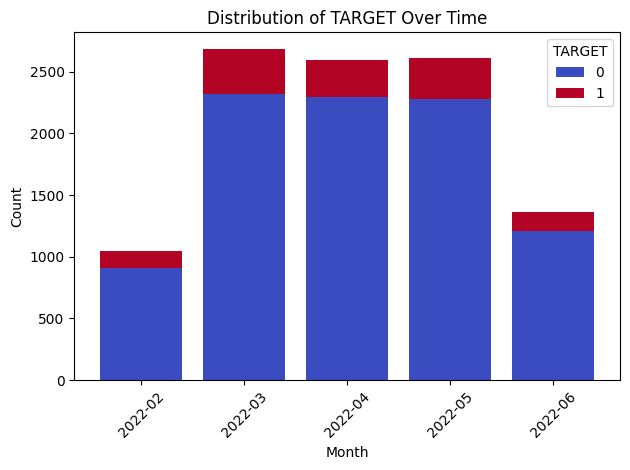

In [16]:
# Plotting the distribution of TARGET over time

# Extracting the month and year for aggregation
df['login_month'] = df['date_time_login'].dt.to_period('M')

# Aggregating the count of TARGET by month
target_time_distribution = df.groupby(['login_month', 'TARGET']).size().unstack(fill_value=0)

# Plotting the time series distribution
plt.figure(figsize=(15, 7))
target_time_distribution.plot(kind='bar', stacked=True, colormap='coolwarm', width=0.8)
plt.title('Distribution of TARGET Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='TARGET')
plt.tight_layout()
plt.show()

In [17]:
df['login_month'] = df['date_time_login'].dt.to_period('M')
target_proportion_over_time = df.groupby('login_month')['TARGET'].mean().reset_index()
target_proportion_over_time

,login_month,TARGET
0,2022-02,0.128107
1,2022-03,0.135991
2,2022-04,0.116243
3,2022-05,0.129304
4,2022-06,0.109478


By analyzing the results of the data exploration, it's possible to notice that:

- This dataset features geographical details, timestamps, and transaction quantities, so it likely comes from a transactional system, such as logistics or retail services. The inclusion of a target variable indicates some delivery or transaction outcome
- The TARGET column is binary, therefore, this presents a classification problem, and classifier models should be used
- The dataset contains 10,303 entries with a mix of numerical, categorical, and datetime columns, with no missing values
- Numerical columns exhibit significant variability, which might impact model performance
- The TARGET column has 12.5% of entries labeled as 1 and the remainder as 0 - this indicates a significant imbalance in the classes, and models might become biased towards the majority class
- The TARGET variable shows weak linear correlations with other numerical features, indicating more complex relationships
- Temporal analysis reveals consistent activity over the observed period, with potential temporal trends affecting the TARGET variable
- Geographical distribution shows varying counts across different states and cities, with certain areas having higher data counts
- The boxplot of the numerical values show that it might be feasible to cap outliers to maintain the consistency of the data
- The proportion of TARGET=1 varies across different states and cities, indicating regional differences
- The proportion of TARGET=1 varies slightly across different dates, indicating time-related variances

Therefore, it's plausible to conclude that all features have some degree of relationship with the target variable, and may be useful for predictive modeling.

<style>
    h4 {
        margin-bottom: 15px;
    }
    ul {
        margin-bottom: 20px;
    }
    li {
        margin-bottom: 10px;
    }
</style>

# Data cleaning/preprocessing

<h4> In this step, the objective is to apply cleaning and preprocessing techniques to the data, based on what was observed from the data exploration.</h4>

This is an initial step to make the data useable for the model, and future adjustments can be made to improve model performance (feature engineering).

In [18]:
# resetting the data to the original since some columns were on the data exploration step
df = deepcopy(data)

In [19]:
# extracting datetime components (year, month, day, hour, minute, second) from 'date_time_login' column
# this allows the model to capture time-based patterns more effectively
# the 'year' won't be used since the data comprises of only a single year, so it's useless in prediction

df['login_month'] = pd.to_datetime(df['date_time_login']).dt.month
df['login_day'] = pd.to_datetime(df['date_time_login']).dt.day
df['login_hour'] = pd.to_datetime(df['date_time_login']).dt.hour
df['login_minute'] = pd.to_datetime(df['date_time_login']).dt.minute
df['login_second'] = pd.to_datetime(df['date_time_login']).dt.second
df['login_weekday'] = pd.to_datetime(df['date_time_login']).dt.weekday

df['confirm_month'] = pd.to_datetime(df['date_time_confirm']).dt.month
df['confirm_day'] = pd.to_datetime(df['date_time_confirm']).dt.day
df['confirm_hour'] = pd.to_datetime(df['date_time_confirm']).dt.hour
df['confirm_minute'] = pd.to_datetime(df['date_time_confirm']).dt.minute
df['confirm_second'] = pd.to_datetime(df['date_time_confirm']).dt.second
df['confirm_weekday'] = pd.to_datetime(df['date_time_confirm']).dt.weekday

df = df.drop(["date_time_login", "date_time_confirm"], axis=1)

In [20]:
df.head(3)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,total_quantity,augmented_quantity,...,login_hour,login_minute,login_second,login_weekday,confirm_month,confirm_day,confirm_hour,confirm_minute,confirm_second,confirm_weekday
0,-400.732711,72.926478,-243.059370,87.928551,568.211458,-314.371508,-601.964793,617.692215,123,569,...,2,14,15,6,6,5,2,14,21,6
1,-880.747368,-956.608685,1254.880642,-295.771103,-4279.430521,-1540.310595,-376.902843,-550.748455,108,184,...,8,4,36,6,5,15,8,4,52,6
2,1466.142174,-254.237053,27.568952,-607.225752,-133.657056,1300.214330,254.241280,970.543987,116,384,...,17,14,40,1,5,3,17,14,49,1


In [21]:
categorical_features = ['FU', 'City']
numerical_features = ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'total_quantity', 'augmented_quantity']
datetime_features = ['login_year', 'login_month', 'login_day', 'login_hour', 'login_minute', 'login_second']

In [22]:
# encoding the categorical variables via label encoding, so that models can interpret them
# note: one of the models (catboost) can deal with categorical variables natively without encoding,
# but it was chosen to encode either way, because it won't affect its performance, and makes code simpler

for col in categorical_features:
    df[col] = LabelEncoder().fit_transform(df[col])

In [23]:
df.head(3)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,total_quantity,augmented_quantity,...,login_hour,login_minute,login_second,login_weekday,confirm_month,confirm_day,confirm_hour,confirm_minute,confirm_second,confirm_weekday
0,-400.732711,72.926478,-243.059370,87.928551,568.211458,-314.371508,-601.964793,617.692215,123,569,...,2,14,15,6,6,5,2,14,21,6
1,-880.747368,-956.608685,1254.880642,-295.771103,-4279.430521,-1540.310595,-376.902843,-550.748455,108,184,...,8,4,36,6,5,15,8,4,52,6
2,1466.142174,-254.237053,27.568952,-607.225752,-133.657056,1300.214330,254.241280,970.543987,116,384,...,17,14,40,1,5,3,17,14,49,1


In [24]:
# separating between input and output variables

X, y = df.drop(["TARGET"], axis=1), df["TARGET"]

Some data was changed and some maintained, the reasoning for that is the following:

- The date was broken into granular time features (year, month, day, hour, minute, second) to make it easier for the model to learn time-based information
- The numerical columns were kept the same since they seem to be on a similar scale, and normalizing might lose some information that could be useful to the model
- The categorical variables (FU, City) were transformed to label encoding, to make it possible for models to interpret these features

This could be a good starting data to train models on - further improvement can be done later, such as adding new features

# Model architecture selection

<h4> In this step, some classification models will be trained and evaluated, considering the imbalance in the data.</h4>
The evaluation will be done using stratified k-fold cross validation, which is a variation of k-fold CV that takes class imbalance into account.<br>

Performance will be measured primarily using the F1-score, as it is not known which value of the TARGET variable is more important. Therefore, both precision and recall can be considered equally important. The model that achieves the best combination of precision and recall will be considered the most suitable for this scenario. <br>

By the nature of the problem, it's expected that the models have higher precision than recall, because they will tend to predict the majority class (0s) more often, leading to fewer false positives and hence higher precision. However, it might miss many true positives, resulting in lower recall.

The following model architetures will be tested (with default parameters):
- Logistic regression
    - The simplest model for classification, it's very fast but not very complex, so it might have trouble with the class imbalance
- SVM classifier
    - A geometry based model that focuses on decision boundaries between classes, tends to do better than logistic regression in some cases
- Random Forest
    - An ensemble based model based on merging decision trees to create a more stable prediction, might handle class imbalance better
- XGBoost
    - A boosting algorithm that minimizes the error at each step, tends to do well on imbalanced datasets, and is very fast and is parallelizable
- CatBoost
    - Another gradient boosting algorithm that has native support for categorical features and handles class imbalance well

<h5>Why not try deep learning?</h5>

Answer: Classical ML algorithms mostly outperform neural network-based approaches on tabular data. This phenomenon has been widely studied in current literature.

Some references include:
- Deep Neural Networks and Tabular Data: A Survey: https://arxiv.org/pdf/2110.01889
- Why do tree-based models still outperform deep learning on typical tabular data?: https://proceedings.neurips.cc/paper_files/paper/2022/file/0378c7692da36807bdec87ab043cdadc-Paper-Datasets_and_Benchmarks.pdf
- Tabular data: Deep Learning is not all you need: https://arxiv.org/pdf/2106.03253

To save time and reduce the complexity of the analysis (neural networks take a long time to train and tune hyperparameters), it was chosen to not include NN based algorithms and instead focus on classical ML approaches.

In [25]:
# function to train and evaluate different model architectures using stratified k-fold

def train_eval_models(X_train, y_train, models, categorical_features=None, k=10):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score)
    }

    for name, model in models.items():
        print(f"Evaluating {name}...")
        start_time = time.time()
        if name == 'CatBoost':
            scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, fit_params={'cat_features': categorical_features})
        else:
            scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)
        end_time = time.time()
        duration = end_time - start_time

        print(f"{name} - Accuracy: {scores['test_accuracy'].mean()}")
        print(f"{name} - F1 score: {scores['test_f1'].mean()}")
        print(f"{name} - Precision: {scores['test_precision'].mean()}")
        print(f"{name} - Recall: {scores['test_recall'].mean()}")
        print(f"{name} - Training duration: {duration:.2f} seconds")
        print("\n")

In [26]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

In [27]:
train_eval_models(X, y, models, categorical_features=categorical_features, k=10)

Evaluating Logistic Regression...
Logistic Regression - Accuracy: 0.8693576789430566
Logistic Regression - F1 score: 0.12581437378278731
Logistic Regression - Precision: 0.388562396209455
Logistic Regression - Recall: 0.07605377906976744
Logistic Regression - Training duration: 0.46 seconds


Evaluating SVC...
SVC - Accuracy: 0.874987899390732
SVC - F1 score: 0.0
SVC - Precision: 0.0
SVC - Recall: 0.0
SVC - Training duration: 8.61 seconds


Evaluating Random Forest...
Random Forest - Accuracy: 0.8787727062989086
Random Forest - F1 score: 0.12645131285984013
Random Forest - Precision: 0.6378813343519226
Random Forest - Recall: 0.07063953488372093
Random Forest - Training duration: 22.44 seconds


Evaluating XGBoost...
XGBoost - Accuracy: 0.884401985064929
XGBoost - F1 score: 0.28989570415888
XGBoost - Precision: 0.6308435316978552
XGBoost - Recall: 0.1910186531007752
XGBoost - Training duration: 2.64 seconds


Evaluating CatBoost...
CatBoost - Accuracy: 0.8984754174003935
CatBoost - F1 

Judging by the results of the evaluation, the following can be concluded:

- **Performance**:
  - CatBoost has the best performance with the highest F1 score.
  - SVC overfits to the majority class.
  - Logistic Regression has low precision and recall.
  - Random Forest shows average precision but very low recall.
  - XGBoost exhibits average precision and low recall.
- **Training Time**:
  - CatBoost is the slowest model during training.
  - Logistic Regression and XGBoost are the fastest.


Caveats:
- Observing the training time, it's possible to notice that CatBoost is the slowest of all algorithms (keep in mind this is using 10-fold CV, so there are 10 model training steps for each CV).
- XGBoost often requires hyperparameter tuning, which might explain why its performance is below CatBoost's.
    - CatBoost also has some hyperparameters that can be tuned, but it often does well on benchmarks even with default parameters.
- CatBoost, despite having higher performance, might be innapropriate for using in production if performance is crucial.
    - In this case, it's recommended to switch to XGBoost, since its speed is vastly superior, and fine-tuning its hyperparameters might extract better performance.

Since the training time is still within an acceptable time frame for this dataset, the chosen architecture will be CatBoost from now on

# Data balancing and Class weighting

<h4> In this step, the main problem of this dataset will be addressed: the class imbalance.</h4>

There are different techniques that can be used to solve this problem, which include:

- Downsampling majority class
    - A random sample of the majority class can be taken, to reduce or eliminate the imbalance
    - Reducing the ratio of majority:minority class can improve model performance, and finding a good ratio requires some experimenting
- Upsampling minority class
    - Some algorithms are able to generate new samples to the minority class, but it's important to ensure that the new samples are representative and do not introduce noise
    - Techniques like SMOTE can be used to generate synthetic samples by interpolating between existing minority class samples
- Adding class weights to model
    - Many machine learning algorithms (including CatBoost) allow class weights to give more importance to the minority class
    - Class weighting can help the model to pay more attention to the minority class, improving its performance

observation: 5 folds will be used instead of 10, for performance reasons.

To test upsampling, downsampling, and class weighting, various ratios (arbitrary numbers between 0 and 1) will be used.

- Downsampling:
    - Suppose the original class distribution is 100 positive:1000 negative samples, giving a ratio of 1:10 = 0.1.
    - If the new chosen ratio is 0.2, the majority class will be downsampled to 1/0.2 = 5 times the size of the minority class.
    - This changes the class distribution to 1:5, or 100 positive:500 negative
- Upsampling:
    - Suppose the original class distribution is 100 positive:1000 negative samples, giving a ratio of 1:10 = 0.1.
    - If the new ratio is 0.2, the minority class will be upsampled to 0.2 times the size of the majority class.
    - This changes the class distribution to 200:1000, or a ratio of 0.2:1.
- Class Weighting:
    - Class weights are given as pairs of ratios, such as (2, 10). The magnitudes do not matter; only the relative values are important.
    - For example, a class weight of (1, 5) is equivalent to (2, 10).
    - These weights represent the importance of the negative class and the positive class, respectively. A higher weight for the negative class means the model will pay more attention to it, and vice versa.

In [28]:
# functions to train catboost models by themselves, or in a cross validation.
# here the cross validation is somewhat "manual" because sklearn's cross_validate
# doesn't work with catboost's Pool data structure.

def train_evaluate_catboost(X_train, y_train, X_test, y_test, class_weights=None, categorical_features=None, return_model=False):
    catboost = CatBoostClassifier(silent=True, random_state=42, class_weights=class_weights)

    train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

    catboost.fit(train_pool, silent=True)
    y_pred = catboost.predict(test_pool)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
    }

    if return_model:
        return catboost, metrics
    else:
        return metrics


def train_evaluate_catboost_CV(X, y, k, class_weights=None, categorical_features=None, sampler=None):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    metrics = defaultdict(list)

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        if sampler:
            X_train_fold, y_train_fold = sampler.fit_resample(X_train_fold, y_train_fold)

        model_metrics = train_evaluate_catboost(X_train_fold, y_train_fold, X_test_fold, y_test_fold, class_weights=class_weights, categorical_features=categorical_features)

        metrics["Accuracy"].append(model_metrics["Accuracy"])
        metrics["F1 score"].append(model_metrics["F1 score"])
        metrics["Precision"].append(model_metrics["Precision"])
        metrics["Recall"].append(model_metrics["Recall"])

    metrics_mean = {
        "Accuracy": np.mean(metrics["Accuracy"]),
        "F1 score": np.mean(metrics["F1 score"]),
        "Precision": np.mean(metrics["Precision"]),
        "Recall": np.mean(metrics["Recall"])
    }

    return metrics_mean

In [29]:
X, y = df.drop(["TARGET"], axis=1), df["TARGET"]

In [30]:
# evaluating models on imbalanced data (no balancing performed)

evaluation = train_evaluate_catboost_CV(X, y, 5, categorical_features=categorical_features)

print(evaluation)

{'Accuracy': 0.8963412520079329, 'F1 score': 0.38372403813418193, 'Precision': 0.7490547244133536, 'Recall': 0.25852562362380477}


In [31]:
# evaluating models on majority downsampling

ratios = [0.2, 0.4, 0.6, 0.8, 1]

for ratio in ratios:
    sampler = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
    evaluation = train_evaluate_catboost_CV(X, y, 5, categorical_features=categorical_features, sampler=sampler)
    print(f"Downsampling ratio: {ratio} - model evaluation:\n{evaluation}")

Downsampling ratio: 0.2 - model evaluation:
{'Accuracy': 0.8976030110748388, 'F1 score': 0.4218495161766329, 'Precision': 0.7187096284667241, 'Recall': 0.2988990438271047}
Downsampling ratio: 0.4 - model evaluation:
{'Accuracy': 0.8878006246378654, 'F1 score': 0.4733904064872784, 'Precision': 0.5727317000213312, 'Recall': 0.40375531626097183}
Downsampling ratio: 0.6 - model evaluation:
{'Accuracy': 0.8681948625184306, 'F1 score': 0.4779902078261552, 'Precision': 0.4733915367283186, 'Recall': 0.4829578017072362}
Downsampling ratio: 0.8 - model evaluation:
{'Accuracy': 0.8181144980992354, 'F1 score': 0.43069148953512537, 'Precision': 0.354485656158506, 'Recall': 0.5489729436250113}
Downsampling ratio: 1 - model evaluation:
{'Accuracy': 0.760168595695369, 'F1 score': 0.38896184935609235, 'Precision': 0.28580709120078024, 'Recall': 0.6095255331342563}


In [32]:
# evaluating models on minority upsampling

ratios = [0.2, 0.4, 0.6, 0.8, 1]

for ratio in ratios:
    sampler = SMOTE(sampling_strategy=ratio, random_state=42)
    evaluation = train_evaluate_catboost_CV(X, y, 5, categorical_features=categorical_features, sampler=sampler)
    print(f"Upsampling ratio: {ratio} - model evaluation:\n{evaluation}")

Upsampling ratio: 0.2 - model evaluation:
{'Accuracy': 0.8955648827273027, 'F1 score': 0.39672896502743205, 'Precision': 0.7142962962962963, 'Recall': 0.2748439055289114}
Upsampling ratio: 0.4 - model evaluation:
{'Accuracy': 0.892944324321778, 'F1 score': 0.4234983472848589, 'Precision': 0.6465571073056021, 'Recall': 0.31522034205049315}
Upsampling ratio: 0.6 - model evaluation:
{'Accuracy': 0.8893535987337657, 'F1 score': 0.43432643028936724, 'Precision': 0.6036061775522155, 'Recall': 0.3393026272132235}
Upsampling ratio: 0.8 - model evaluation:
{'Accuracy': 0.8836267623879444, 'F1 score': 0.41779947713543, 'Precision': 0.5587021663682052, 'Recall': 0.333885319578922}
Upsampling ratio: 1 - model evaluation:
{'Accuracy': 0.8769302299289157, 'F1 score': 0.411574658201782, 'Precision': 0.5132962247204117, 'Recall': 0.34396585527704887}


In [33]:
# evaluating models on class weighting

ratios = [0.1, 0.2, 0.3, 0.4, 0.6]

for ratio in ratios:
    class_weights = [ratio, 1]
    evaluation = train_evaluate_catboost_CV(X, y, 5, categorical_features=categorical_features, class_weights=class_weights)
    print(f"Class weights [0/1]: {class_weights} - model evaluation:\n{evaluation}")

Class weights [0/1]: [0.1, 1] - model evaluation:
{'Accuracy': 0.850141933174112, 'F1 score': 0.46624867185442687, 'Precision': 0.4204984861325743, 'Recall': 0.5233101076825626}
Class weights [0/1]: [0.2, 1] - model evaluation:
{'Accuracy': 0.8871211543081641, 'F1 score': 0.4875021850012036, 'Precision': 0.563989164797843, 'Recall': 0.4293638584743462}
Class weights [0/1]: [0.3, 1] - model evaluation:
{'Accuracy': 0.8938177809810488, 'F1 score': 0.46979881198586665, 'Precision': 0.6254007445237102, 'Recall': 0.376542092721624}
Class weights [0/1]: [0.4, 1] - model evaluation:
{'Accuracy': 0.8961473598922194, 'F1 score': 0.4552743909659114, 'Precision': 0.6622886557265056, 'Recall': 0.34705154887943773}
Class weights [0/1]: [0.6, 1] - model evaluation:
{'Accuracy': 0.8964383393865736, 'F1 score': 0.4210047967856336, 'Precision': 0.7018504645531909, 'Recall': 0.30122764154073545}


Analyzing the Results:

- The ideal strategy in this case seems to be using class weighting, since it gives the most F1 score (0.487)
    - Ideal class weighting: 0.2:1 = 1:5
- Both undersampling and upsampling can be used, but loss of information and addition of noise must be taken into consideration
    - Undersampling has the edge due to lower training time
- If the goal is to enhance recall (in case the positive class is the most important), downsampling the majority class seems to be the best option
    - Trade-off: This approach significantly reduces precision, highlighting the trade-off between recall and precision

# Feature importance

<h4> After experimenting with data balancing/ class weighting, it's plausible to analyze what features are impacting the model the most, so that it's possible to try adding new features based on the most important ones. </h4>

To perform this, SHAP (SHapley Additive exPlanations) can be used, which is a unified approach to explain the output of models. 

SHAP offers advantages over traditional feature importance methods, such as:
- Providing both global and local interpretability: SHAP shows the overall importance of each feature (global) and how each feature contributes to individual predictions (local)
- Consistent and fair attribution: SHAP is based on Shapley values from game theory, ensures a fair and consistent distribution of contributions among features, unlike heuristics like Gini impurity or information gain, which can be inconsistent and biased


In [34]:
ratio = 0.2
class_weights = [ratio, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
model, _ = train_evaluate_catboost(X_train, y_train, X_test, y_test, class_weights=class_weights, categorical_features=categorical_features, return_model=True)

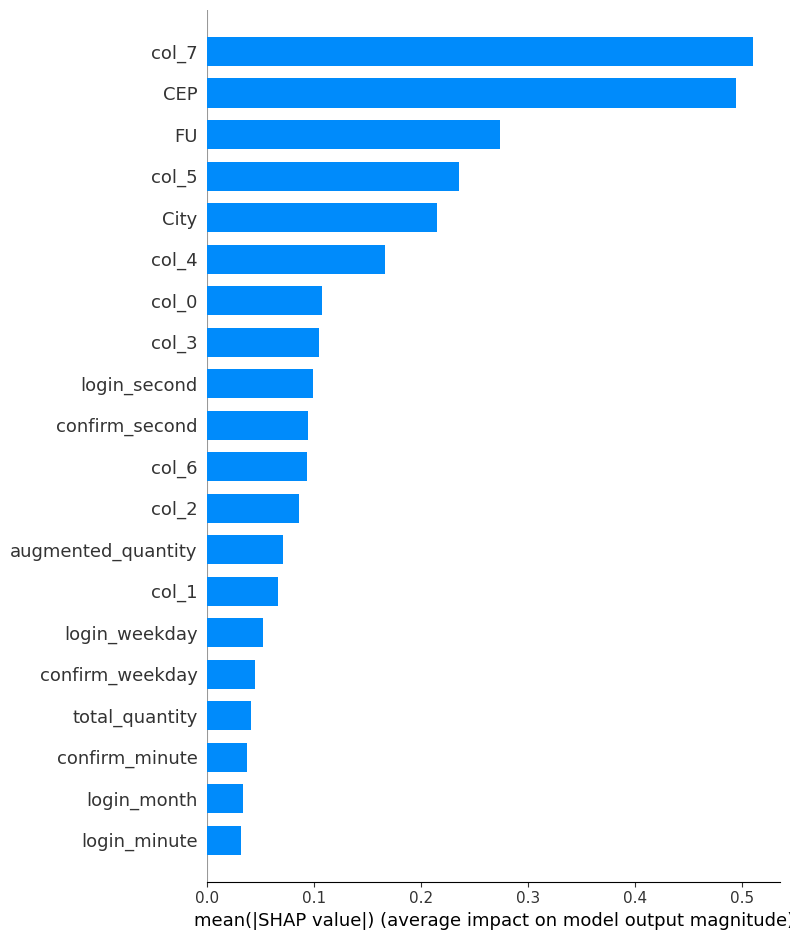

In [36]:
# model feature importance bar plot

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

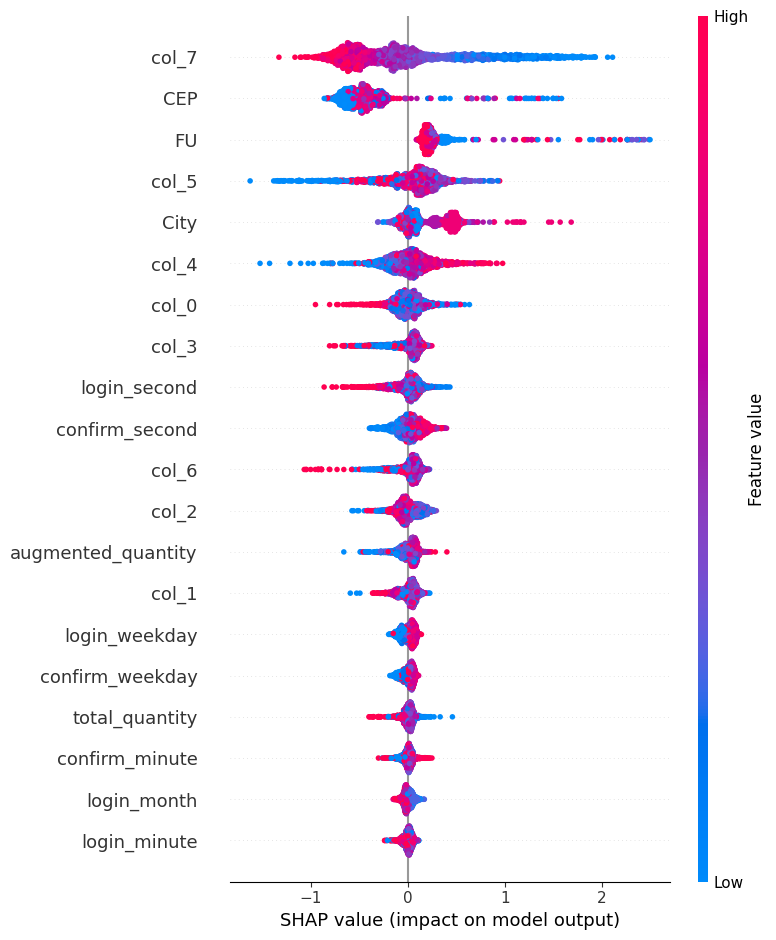

In [37]:
# SHAP beeswarm plot

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

From this step, it's noticeable that the "col_x" variables have a high impact on the model, especially col_7. High values (red) of col_7 tend to decrease the probability of the positive class, while low values (blue) increase it, so there is a "negative" association.

Also, location-based features exhibited a high impact on model output, with CEP and FU being the 2nd and the 3rd most important feature. It's hard to pin down the exact interaction between these variables and the target variable, but it's plausible to infer that:
- Higher CEP number is associated with higher probability of negative class, indicating that cities with smaller CEP code numbers are more likely to be associated with the 0 class
- FU is not a number, so the association of higher/lower values with the class probability does not lead to any insights

Also, date-time values seem to have a moderate effect on the model performance, with the highest value being the login_second and confirm_second - those values apparently have a positive association with the class (higher value = higher probability of positive class).

This indicates that the target variable is related to geographical data, and signalizes that extracting more information from them might improve performance

# Feature Engineering

<h4>Using results from feature importance analysis, it's beneficial to create new features for the model and evaluate if their inclusion enhances performance. </h4>

Domain knowledge is crucial in this step - since the dataset source is unknown and some columns have arbitrary names, the possibilities are somewhat limited.

Potential new features include:

- Calculating relative quantity from total and augmented quantity:
    - This calculation is simple, though these variables are not the most important to the model.
- Calculating time difference from login to confirmation
    - This calculation might be useful in capturing behaviors from users, which might have an impact on the model
- Extracting latitude/longitude from the postal code (CEP) (requires external APIs):
    - Location-based features (CEP and FU) had a high impact on the model. More precise latitude/longitude features might provide additional useful information, as the model cannot inherently infer the spatial nature of CEP and FU.
- Interaction between the two most important "col_x" values: col_5 and col_7
    - A simple multiplication of the two features will be added to the feature set

Finally, a feature selection algorithm will be ran, to remove potentially irrelevant features that might hold back performance.

In [38]:
# first, checking baseline performance before adding new features

train_evaluate_catboost_CV(X, y, k=5, categorical_features=categorical_features, class_weights=class_weights)

{'Accuracy': 0.8871211543081641,
 'F1 score': 0.4875021850012036,
 'Precision': 0.563989164797843,
 'Recall': 0.4293638584743462}

In [39]:
# creating new features and adding to current df

# new feature 1
relative_quantity = pd.Series(df["augmented_quantity"]/df["total_quantity"], name="relative_quantity")

# new features 2
df_locations = pd.read_csv("locations_data.csv")
df_locations = df_locations[["address", "district", "lat", "lng"]]
location_categorical_features = ["address", "district"]

for col in location_categorical_features:
    df_locations[col] = df_locations[col].apply(lambda x: "" if pd.isnull(x) else x)
    df_locations[col] = df_locations[col].astype(str)

# feature 3
time_delta = pd.to_datetime(data["date_time_confirm"]) - pd.to_datetime(data["date_time_login"])
delta_seconds = pd.Series(time_delta.dt.total_seconds(), name="delta_seconds")

# feature 4
col_5_7 = pd.Series(df["col_5"] * df["col_7"], name="col_5_7")

# combining new features with existing dataset
df_features = pd.concat([df, df_locations, delta_seconds, col_5_7], axis=1)
X, y = df_features.drop(columns=["TARGET"]), df_features["TARGET"]

In [40]:
# evaluating CV performance in data with new features

train_evaluate_catboost_CV(X, y, k=5, categorical_features=location_categorical_features, class_weights=class_weights)

{'Accuracy': 0.8962454836232766,
 'F1 score': 0.5636334539519418,
 'Precision': 0.5962817979923244,
 'Recall': 0.5349530962507163}

In [41]:
# picking a model to generate SHAP beeswarm plot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model, _ = train_evaluate_catboost(X_train, y_train, X_test, y_test, class_weights=class_weights, categorical_features=location_categorical_features, return_model=True)

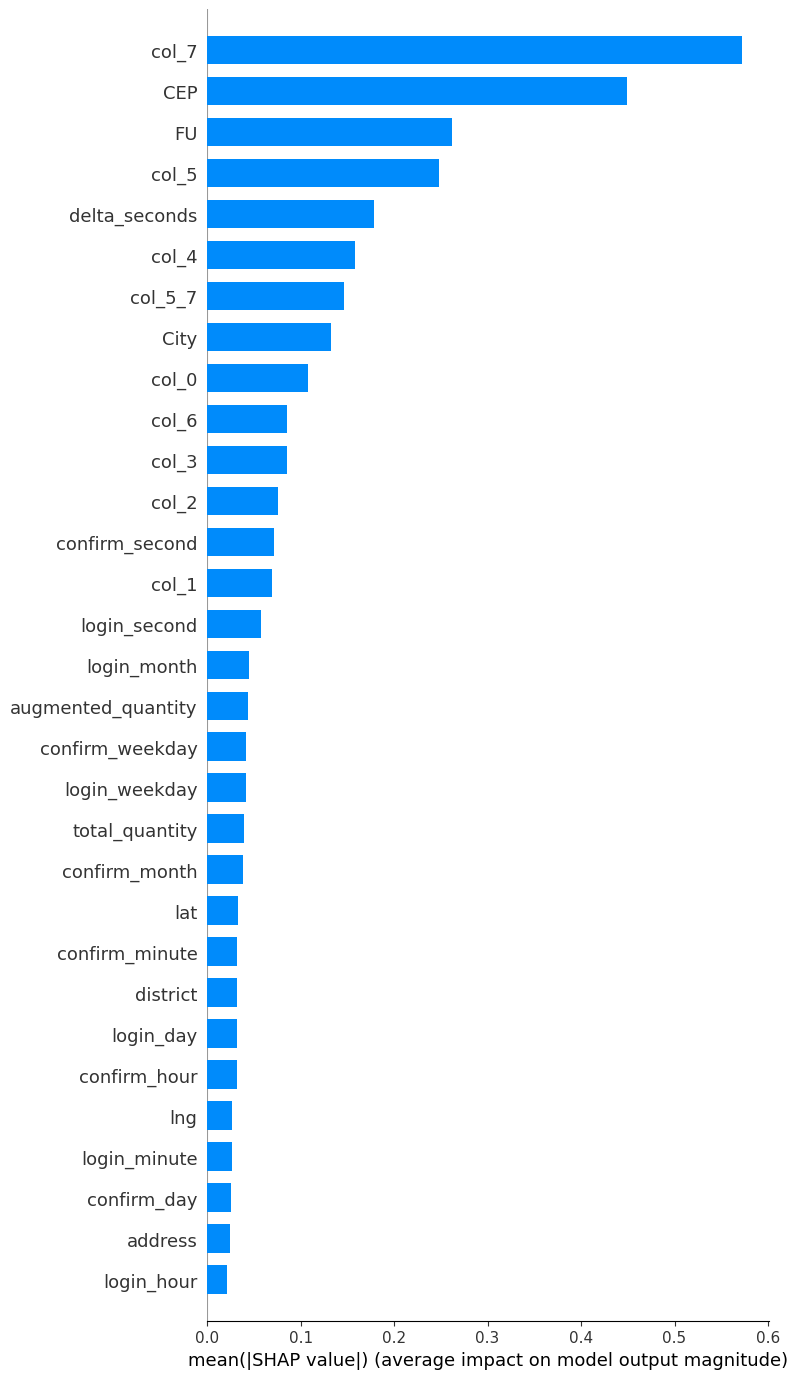

In [42]:
# SHAP beeswarm plot

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=X.shape[1])

In [43]:
# perform feature selection

model = CatBoostClassifier(random_seed=42, silent=True)
train_pool = Pool(data=X_train, label=y_train, cat_features=location_categorical_features)

summary = model.select_features(
    train_pool,
    features_for_select='0-30',
    num_features_to_select=X_train.shape[1] // 2,
    steps=3,
    logging_level='Silent'
)

In [44]:
# checking which features were selected

selected_features = summary["selected_features_names"]
selected_features

['col_0',
 'col_1',
 'col_2',
 'col_3',
 'col_4',
 'col_5',
 'col_6',
 'col_7',
 'FU',
 'City',
 'CEP',
 'confirm_minute',
 'confirm_second',
 'delta_seconds',
 'col_5_7']

In [45]:
# evaluating new features with feature selection

X = X[selected_features]
train_evaluate_catboost_CV(X, y, k=5, class_weights=class_weights, categorical_features=categorical_features)

{'Accuracy': 0.8949834890217303,
 'F1 score': 0.5753367475082504,
 'Precision': 0.5828391911966468,
 'Recall': 0.5683377069948421}

Judging by the results of the feature engineering, the performance had a significant improvement, from F1 = 0.487 to F1 = 0.575.

These results can be boiled down to:

- Most of the improvement came in the form of the time_delta variable, which became one of the most important features
- Unfortunately, the new location features did not bring useful new information to the model, and were discarded in feature selection
- The interaction between col_5 and col_7 had moderate impact on the model, and was maintained after feature selection
- The relative quantity did not bring meaningful information, and was discarded in feature selection

This was the the final experimentation step, the next step now is to just export the model.

# Training final model

<h4> In the final step, a model will be trained on 90% of the dataset and evaluated on the last 10%. This is to make sure that the performance is comparable to what was achieved previously.</h4>

The model will have a combination of the following techniques:

- Catboost model with categorical features
- Class weighting: 0.2:1 ratio
- New features from feature engineering
- Feature selection

After that, the model can be deployed to production, and be used for predictions.

In [46]:
# returning FU and City to strings, and transforming them into categorical type
# previously it was encoded, but it's not suitable for prediction when it's encoded

X['FU'] = data['FU'].astype('category')
X['City'] = data['City'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

final_model, evaluation = train_evaluate_catboost(X_train, y_train, X_test, y_test, class_weights=class_weights, categorical_features=categorical_features, return_model=True)
evaluation

{'Accuracy': 0.9097963142580019,
 'F1 score': 0.6436781609195402,
 'Precision': 0.6412213740458015,
 'Recall': 0.6461538461538462}

In [47]:
final_model.save_model("catboost_model_v0")

# Model deployment discussion

This project includes a deployment of the model as an API server wrapper in a docker container. This ensures that the model can be run in any system, regardless of its specifications, and it can be readily deployed to a container hosting platform with simple commands.

The model inference speed was measured in a localhost environment in the file located at test_model_inference_speed.ipynb.

The test resulted in approximately 0.21 seconds to predict every 1000 samples, which likely means that it's suitable to be used in production for small scale inference. The performance is likely to be inferior if the application runs in the cloud, since there's communication overhead that doesn't happen locally.

To upload the model to the cloud, there are some alternatives:
- Deploy in a model deployment platform, such as AWS SageMaker or GCP AI Platform
- Run model in a container in EKS (AWS kubernetes) or GKE (GCP kubernetes)

There are different strenghts associated with each option:
- Specialized platforms: Higher performance out-of-the-box, less management, but less room for customization
- Container based platforms: Higher customization, can have higher performance if adjusted correctly, but requires expertise to fine tune deployment

There's no right strategy - the deployment strategy depends on factors such as platform cost, team expertise, and integration with other platforms.

# Further improvements

<h4>Many different iterations of experimenting were run, to varying success. There are also many other procedures that can be tried, but due to lack of time/computing power were not possible. Those include: </h4>

- <b>Generating more features</b>: having more information about the dataset, it's possible to generate better features, generating better variable combinations derived from domain knowledge
- <b>Hyperparameter tuning</b>: although Catboost is a model that generally performs well with minimal parameter tuning, doing so might lead to performance improvements. This process can be made easier using GridSearchCV from Sklearn. Note: I didn't run this due to a lack of time.
- <b>Training deep learning models</b>: although classical ML is generally better than Deep Learning, it doesn't mean that it's universally the best option. This dataset might be suited for a NN-based model, but experimenting can be time consuming and require powerful computing
- <b>Generating more data</b>: The best option to improve ML models is and will always be adding more data. In this case, adding more data to the minority class, so that models have an easier time learning the relationship between variables without being susceptible to overfitting

<style>
    h4 {
        margin-bottom: 15px;
    }
    ul {
        margin-bottom: 20px;
    }
    li {
        margin-bottom: 10px;
    }
</style>

# Closing Thoughts

In this notebook, a comprehensive predictive analysis was conducted, addressing various data challenges.

The key takeaways are:

- Class imbalance requires careful consideration. Since the importance of each class remains unknown, model evaluations must account for this uncertainty
- The 'col_x' features are the most significant predictors of the target class, while geographical and temporal data have a moderate impact
- Generating new features, removing less useful features, and optimizing the class balancing ratio significantly improve performance

**Thank you for the opportunity, Cayena team!**<br>
*Matheus Nunes*


<small>disclaimer: Generative AI (LLM model - Chat GPT 4) was used to help with this work. The LLM was used only to improve writing in some explanations and writing some code given my instructions, and every decision made in this work is my own.</small>